## Example usage of `error-parity` with other fairness-constrained classifiers

Contents:
1. Train a standard (unconstrained) model;
2. Check attainable fairness-accuracy trade-offs via post-processing, with the `error-parity` package;
3. Train fairness-constrained model (in-processing fairness intervention), with the `fairlearn` package;
5. Map results for post-processing + in-processing interventions;

---

**NOTE**: This notebook has the following extra requirements: `fairlearn` `lightgbm`.

Install them with ```pip install fairlearn lightgbm```

In [1]:
import os
import numpy as np

In [2]:
from error_parity import __version__
print(f"error-parity=={__version__}")

error-parity==0.3.8


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="whitegrid", rc={"grid.linestyle": "--", "figure.dpi": 200, "figure.figsize": (4,3)})

Some useful global constants:

In [4]:
SEED = 2

TEST_SIZE = 0.3
VALIDATION_SIZE = None

PERF_METRIC = "accuracy"
DISP_METRIC = "equalized_odds_diff"

N_JOBS = max(2, os.cpu_count() - 2)

np.random.seed(SEED)

### Fetch UCI Adult data

We'll use the `sex` column as the sensitive attribute.
That is, false positive (FP) and false negative (FN) errors should not disproportionately impact individuals based on their sex.

In [5]:
SENSITIVE_COL = "sex"
sensitive_col_map = {"Male": 0, "Female": 1}

# NOTE: You can also try to run this using the `race` column as sensitive attribute (as commented below).
# SENSITIVE_COL = "race"
# sensitive_col_map = {"White": 0, "Black": 1, "Asian-Pac-Islander": 1, "Amer-Indian-Eskimo": 1, "Other": 1}

sensitive_col_inverse = {val: key for key, val in sensitive_col_map.items()}

POS_LABEL = ">50K"

Download data.

In [6]:
from fairlearn.datasets import fetch_adult

X, Y = fetch_adult(
    as_frame=True,
    return_X_y=True,
)

# Map labels and sensitive column to numeric data
Y = np.array(Y == POS_LABEL, dtype=int)
S = np.array([sensitive_col_map[elem] for elem in X[SENSITIVE_COL]], dtype=int)

Split in train/test/validation data.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other, s_train, s_other = train_test_split(
    X, Y, S,
    test_size=TEST_SIZE + (VALIDATION_SIZE or 0),
    stratify=Y, random_state=SEED,
)

if VALIDATION_SIZE is not None and VALIDATION_SIZE > 0:
    X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
        X_other, y_other, s_other,
        test_size=TEST_SIZE / (TEST_SIZE + VALIDATION_SIZE),
        stratify=y_other, random_state=SEED,
    )
else:
    X_test, y_test, s_test = X_other, y_other, s_other
    X_val, y_val, s_val = X_train, y_train, s_train

Log the accuracy attainable by a dummy constant classifier.

In [8]:
def compute_constant_clf_accuracy(labels: np.ndarray) -> float:
    return max((labels == const_pred).mean() for const_pred in np.unique(labels))

constant_clf_accuracy = {
    "train": compute_constant_clf_accuracy(y_train),
    "test": compute_constant_clf_accuracy(y_test),
    "validation": compute_constant_clf_accuracy(y_val),
}
constant_clf_accuracy

{'train': 0.7607125098715961,
 'test': 0.7607315908005187,
 'validation': 0.7607125098715961}

### Train a standard (unconstrained) classifier

In [9]:
from lightgbm import LGBMClassifier

unconstr_clf = LGBMClassifier(verbosity=-1)
unconstr_clf.fit(X_train, y_train)

LGBMClassifier(verbosity=-1)

In [10]:
from error_parity.evaluation import evaluate_predictions_bootstrap

unconstr_test_results = evaluate_predictions_bootstrap(
    y_true=y_test,
    y_pred_scores=unconstr_clf.predict(X_test, random_state=SEED).astype(float),
    sensitive_attribute=s_test,
)

print(
    f"In-processing model: \n"
    f">       accuracy = {unconstr_test_results['accuracy_mean']:.3}\n"
    f"> equalized odds = {unconstr_test_results['equalized_odds_diff_mean']:.3}\n"
)

In-processing model: 
>       accuracy = 0.87
> equalized odds = 0.0673



### Map attainable fairness-accuracy trade-offs via (relaxed) post-processing

By varying the tolerance (or slack) of the fairness constraint we can map the different trade-offs attainable by the same model (each trade-off corresponds to a different post-processing intervention).

**Post-processing** fairness methods intervene on the predictions of an already trained model, using different (possibly randomized) thresholds to binarize predictions of different groups.

We'll be using the [`error-parity`](https://github.com/socialfoundations/error-parity) package [[Cruz and Hardt, 2023]](https://arxiv.org/abs/2306.07261).

In [11]:
from error_parity.pareto_curve import compute_postprocessing_curve

# Data to fit postprocessing adjustment
fit_data = (X_train, y_train, s_train)
# fit_data = (X_val, y_val, s_val)

# Common kwargs for the `compute_postprocessing_curve` call
compute_postproc_kwargs = dict(
    fit_data=fit_data,
    eval_data={
        "validation": (X_val, y_val, s_val),
        "test": (X_test, y_test, s_test),
    },
    fairness_constraint="equalized_odds",
    tolerance_ticks=np.hstack((
        np.arange(0.0, 0.1, 1e-2),
        np.arange(0.1, 1.0, 1e-1),
    )),
    bootstrap=True,
    n_jobs=N_JOBS,
    seed=SEED,
)

postproc_results_df = compute_postprocessing_curve(
    model=unconstr_clf,
    y_fit_pred_scores=unconstr_clf.predict_proba(fit_data[0])[:, -1],
    **compute_postproc_kwargs,
)

  0%|          | 0/19 [00:00<?, ?it/s]

### Plot post-processing adjustment frontier

In [12]:
SHOW_RESULTS_ON = "test"
# SHOW_RESULTS_ON = "validation"

ax_kwargs = dict(
    xlim=(constant_clf_accuracy[SHOW_RESULTS_ON] - 5e-3, 0.885),
    ylim=(0.0, 0.3),
    title="Random Hyperparameter Search (val.)",
    xlabel=PERF_METRIC + r"$\rightarrow$",
    ylabel="equalized odds (diff.) $\leftarrow$" if DISP_METRIC == "equalized_odds_diff" else DISP_METRIC,
)

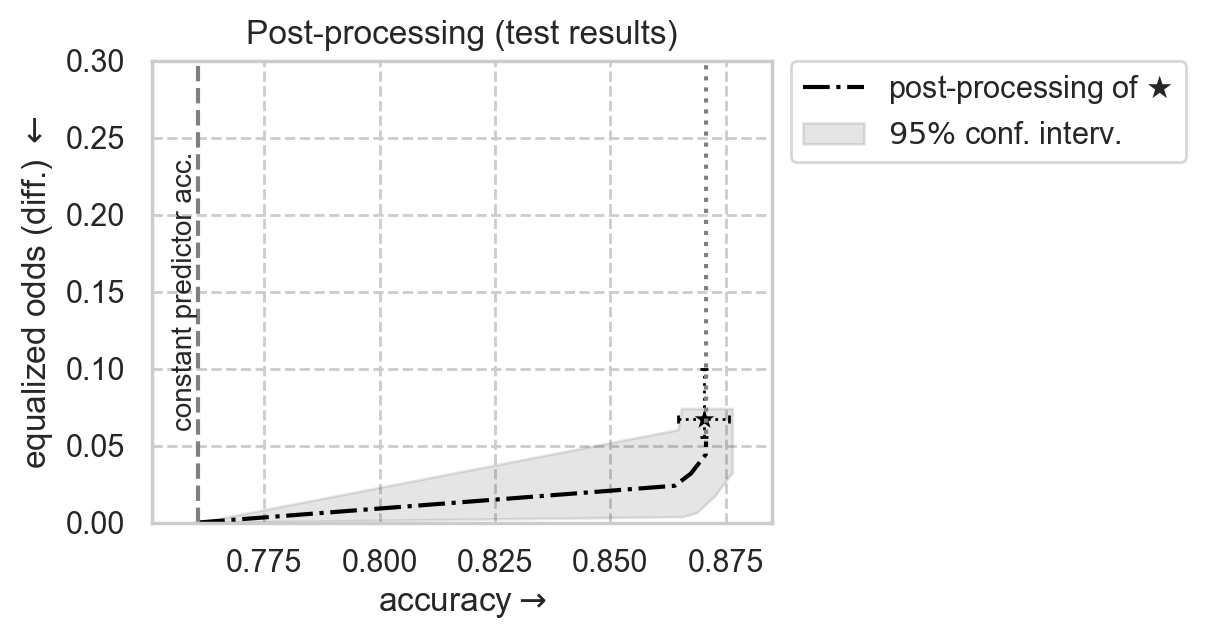

In [13]:
from error_parity.plotting import plot_postprocessing_frontier

# Plot unconstrained model results with 95% CIs
unconstr_performance = unconstr_test_results[f"{PERF_METRIC}_mean"]
unconstr_disparity = unconstr_test_results[f"{DISP_METRIC}_mean"]

sns.scatterplot(
    x=[unconstr_performance],
    y=[unconstr_disparity],
    color="black",
    marker="*",
    s=100,
)

plt.plot(
    (unconstr_test_results[f"{PERF_METRIC}_low-percentile"], unconstr_test_results[f"{PERF_METRIC}_high-percentile"]),
    (unconstr_disparity, unconstr_disparity),
    color="black",
    ls=":",
    marker="|",
    lw=1,
    ms=3,
)

plt.plot(
    (unconstr_performance, unconstr_performance),
    (unconstr_test_results[f"{DISP_METRIC}_low-percentile"], unconstr_test_results[f"{DISP_METRIC}_high-percentile"]),
    color="black",
    ls=":",
    marker="_",
    lw=1,
    ms=3,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    constant_clf_perf=constant_clf_accuracy[SHOW_RESULTS_ON],
    model_name=r"$\bigstar$",
)

# Vertical line with minimum "useful" accuracy on this data
curr_const_clf_acc = constant_clf_accuracy[SHOW_RESULTS_ON]
plt.axvline(
    x=curr_const_clf_acc,
    ls="--",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(curr_const_clf_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON} results)"
ax_kwargs["xlim"] = (curr_const_clf_acc - 1e-2, 0.885)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)
plt.show()

### Let's train another type of fairness-aware model

**In-processing** fairness methods introduce fairness criteria during model training.

_Main disadvantage_: state-of-the-art in-processing methods can be considerably slower to run (e.g., increasing training time by 20-100 times).

We'll be using the [`fairlearn`](https://github.com/fairlearn/fairlearn) package [[Weerts et al., 2020]](https://arxiv.org/abs/2303.16626).

In [14]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

inproc_clf = ExponentiatedGradient(
    estimator=unconstr_clf,
    constraints=EqualizedOdds(),
    max_iter=10,
)

Fit the `ExponentiatedGradient` [[Agarwal et al., 2018]](https://proceedings.mlr.press/v80/agarwal18a.html) in-processing intervention (**note**: may take a few minutes to fit).

In [15]:
%%time
inproc_clf.fit(X_train, y_train, sensitive_features=s_train)

CPU times: user 1min 19s, sys: 1min 21s, total: 2min 40s
Wall time: 39.2 s


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x11bd3abc0>,
                      estimator=LGBMClassifier(verbosity=-1), max_iter=10,
                      nu=0.000851617415307666)

Evaluate in-processing model on test data.

In [16]:
from error_parity.evaluation import evaluate_predictions_bootstrap

inproc_test_results = evaluate_predictions_bootstrap(
    y_true=y_test,
    y_pred_scores=inproc_clf.predict(X_test, random_state=SEED).astype(float),
    sensitive_attribute=s_test,
)

print(
    f"In-processing model: \n"
    f">       accuracy = {inproc_test_results['accuracy_mean']:.3}\n"
    f"> equalized odds = {inproc_test_results['equalized_odds_diff_mean']:.3}\n"
)

In-processing model: 
>       accuracy = 0.867
> equalized odds = 0.0498



**We can go one step further and post-process this in-processing model :)**

In [17]:
from error_parity.pareto_curve import compute_postprocessing_curve

inproc_postproc_results_df = compute_postprocessing_curve(
    model=inproc_clf,
    y_fit_pred_scores=inproc_clf._pmf_predict(fit_data[0])[:, -1],
    predict_method="_pmf_predict",
    **compute_postproc_kwargs,
)

  0%|          | 0/19 [00:00<?, ?it/s]

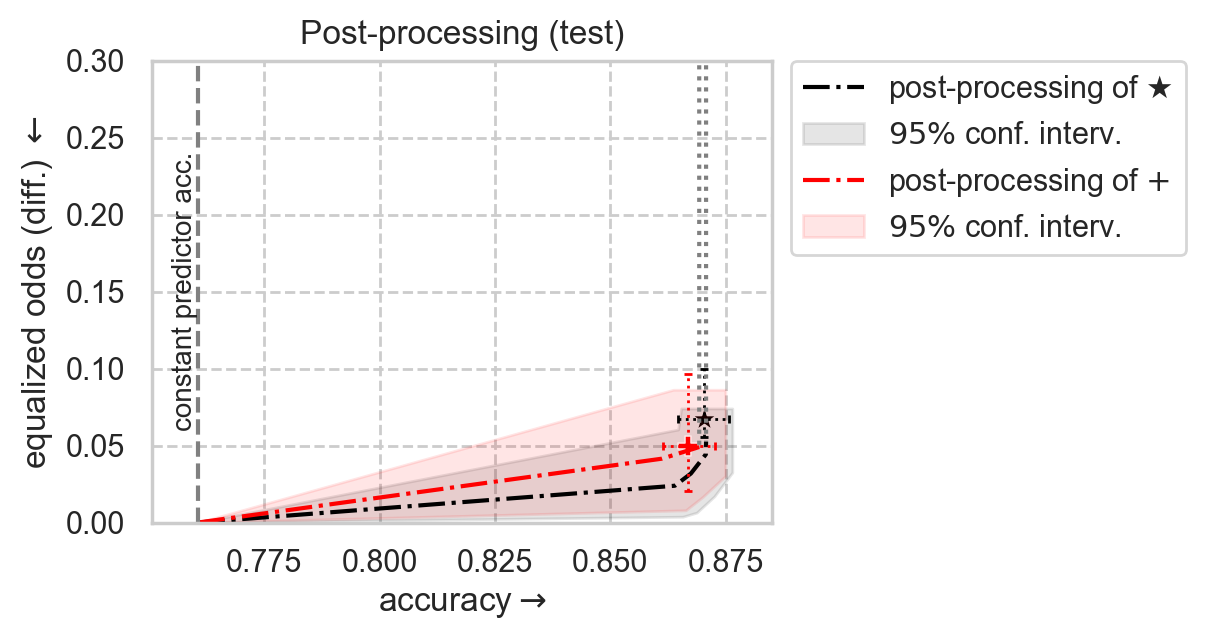

In [18]:
# Plot unconstrained model results with 95% CIs
sns.scatterplot(
    x=[unconstr_performance],
    y=[unconstr_disparity],
    color="black",
    marker="*",
    s=100,
)

plt.plot(
    (unconstr_test_results[f"{PERF_METRIC}_low-percentile"], unconstr_test_results[f"{PERF_METRIC}_high-percentile"]),
    (unconstr_disparity, unconstr_disparity),
    color="black",
    ls=":",
    marker="|",
    lw=1,
    ms=3,
)

plt.plot(
    (unconstr_performance, unconstr_performance),
    (unconstr_test_results[f"{DISP_METRIC}_low-percentile"], unconstr_test_results[f"{DISP_METRIC}_high-percentile"]),
    color="black",
    ls=":",
    marker="_",
    lw=1,
    ms=3,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    constant_clf_perf=constant_clf_accuracy[SHOW_RESULTS_ON],
    model_name=r"$\bigstar$",
)

# Plot inprocessing intervention results with 95% CIs
sns.scatterplot(
    x=[inproc_test_results[f"{PERF_METRIC}_mean"]],
    y=[inproc_test_results[f"{DISP_METRIC}_mean"]],
    color="red",
    marker="P",
    s=50,
)

plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_low-percentile"], inproc_test_results[f"{PERF_METRIC}_high-percentile"]),
    (inproc_test_results[f"{DISP_METRIC}_mean"], inproc_test_results[f"{DISP_METRIC}_mean"]),
    color='red',
    ls=":",
    marker="|",
    lw=1,
    ms=3,
)

plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_mean"], inproc_test_results[f"{PERF_METRIC}_mean"]),
    (inproc_test_results[f"{DISP_METRIC}_low-percentile"], inproc_test_results[f"{DISP_METRIC}_high-percentile"]),
    color='red',
    ls=":",
    marker="_",
    lw=1,
    ms=3,
)

# Plot postprocessing of inprocessing model
plot_postprocessing_frontier(
    inproc_postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    constant_clf_perf=constant_clf_accuracy[SHOW_RESULTS_ON],
    model_name=r"$+$",
    color="red",
)

# Vertical line with minimum "useful" accuracy on this data
curr_const_clf_acc = constant_clf_accuracy[SHOW_RESULTS_ON]
plt.axvline(
    x=curr_const_clf_acc,
    ls="--",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(curr_const_clf_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON})"
ax_kwargs["xlim"] = (curr_const_clf_acc - 1e-2, 0.885)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)

plt.show()

---